In [1]:
import pandas as pd
import numpy as np
import pyranges as pr
import os
import sys
from collections import Counter
import gget
import scipy
import scanpy as sc
from kneed import KneeLocator
import sklearn.metrics
import sklearn.preprocessing as skprep

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from importlib import reload

"""WARNING: disabling future warnings"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append("../")
import utils as ut
reload(ut)

<module 'utils' from '/home/cstansbu/git_repositories/ONT-single-cell/notebooks/utils.py'>

In [2]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/results/HSC/scanpy/anndata.tabula.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 35830 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'

Text(0.5, 1.0, 'iHSC Data')

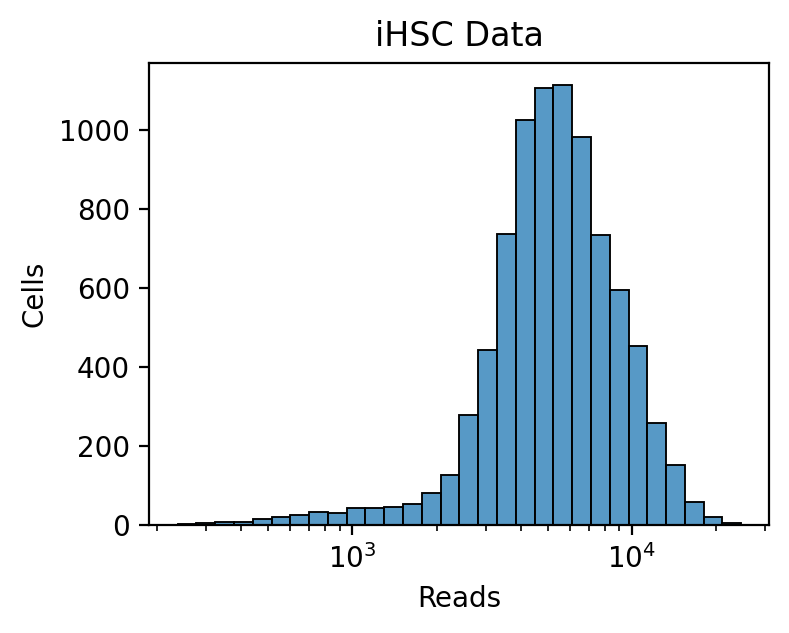

In [3]:
counts = adata[adata.obs['set'] == 'our_data', :].to_df(layer='raw_counts')
sum_counts = counts.sum(axis=1)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3
sns.histplot(data=sum_counts,
             bins=30,
             log_scale=True)

plt.ylabel("Cells")
plt.xlabel("Reads")
plt.title('iHSC Data')

8755.0
9988.0


Text(0.5, 1.0, 'Tabula Sapiens Data')

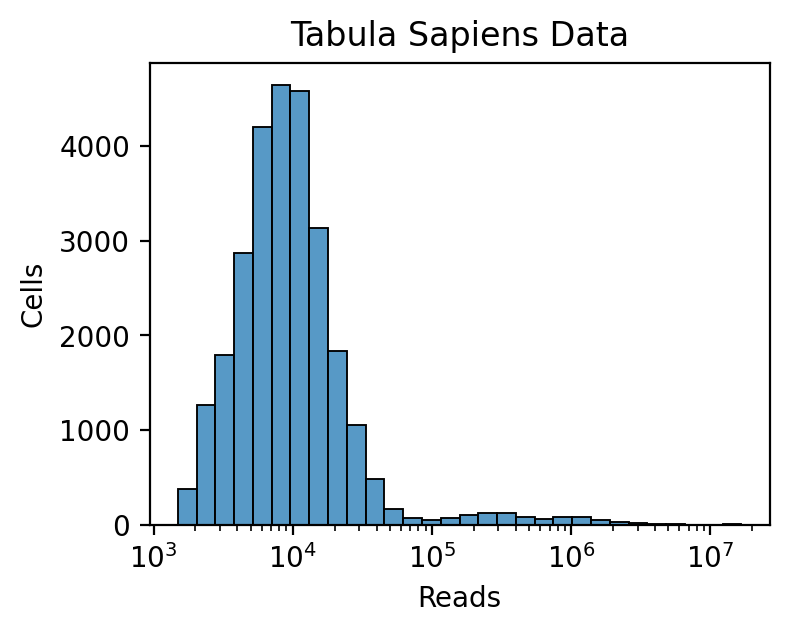

In [31]:
counts = adata[adata.obs['set'] == 'ref_data', :].to_df(layer='raw_counts')
sum_counts = counts.sum(axis=1)

print(np.median(sum_counts))
print(np.median(counts.sum(axis=0)))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3
sns.histplot(data=sum_counts,
             bins=30,
             log_scale=True)

plt.ylabel("Cells")
plt.xlabel("Reads")
plt.title('Tabula Sapiens Data')

In [6]:
pdf = adata[adata.obs['set'] == 'our_data', :].copy()
pdf

AnnData object with n_obs × n_vars = 8484 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'

In [16]:
X = pdf.to_df(layer='raw_counts')
print(f"{X.shape=}")
X.head()

X.shape=(8484, 14599)


gene_name,ATAD3B,SKI,PEX14,PLCH2,SPSB1,HES3,PLEKHM2,CA6,NMNAT1,CCDC27,...,RBMY1A1,CDY1,TSPY4,KDM5D,BPY2C,CDY2B,SRY,VCY,DAZ1,RBMY1E
AAACCCAAGGTTACCT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
AAACCCAAGTTGAAGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
AAACCCAAGTTGTCGT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
AAACCCACAGAAGCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAGGAGGTT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0


median=598.0


gene_name
ATAD3B     568.0
SKI       2457.0
PEX14      384.0
PLCH2      268.0
SPSB1        5.0
dtype: float64

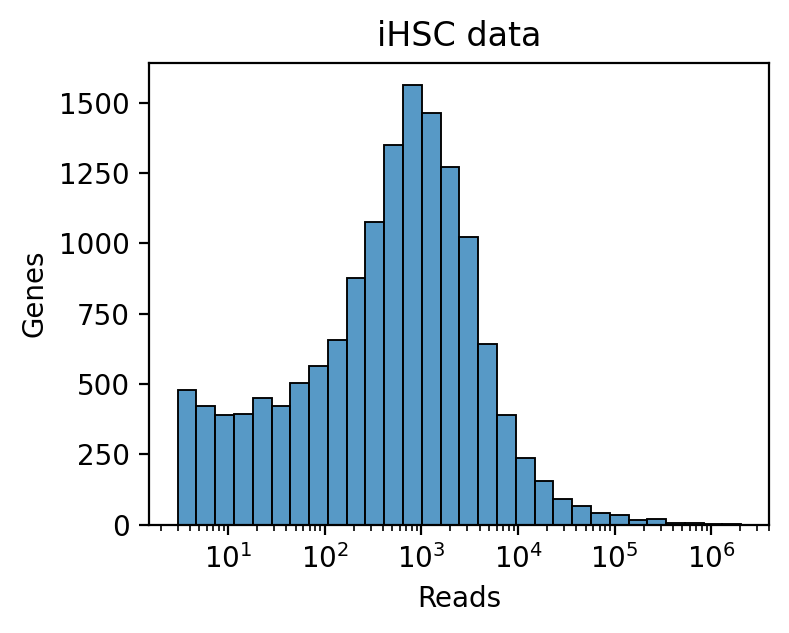

In [33]:
gene_counts = X.sum(axis=0)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3
sns.histplot(x=gene_counts,
             bins=30,
             log_scale=True)

median = np.median(gene_counts)
print(f"{median=}")

# plt.axvline(x=median, c='r', ls=":")

plt.ylabel("Genes")
plt.xlabel("Reads")
plt.title("iHSC data")

gene_counts.head()

In [29]:
cell_counts = X.sum(axis=1)

median = np.median(cell_counts)
mean = np.mean(cell_counts)

print(f"{median=}")
print(f"{mean=}")

median=5339.0
mean=5930.557402168788


In [34]:
gene_counts.sort_values(ascending=False).head(10)

gene_name
CEACAM3    2045267.0
ATG12       894484.0
MINDY1      801539.0
PSEN2       692765.0
TMEM168     617625.0
TUBA1A      582045.0
KLF2        521290.0
ASB1        510078.0
SPTBN1      471532.0
IL4I1       396405.0
dtype: float64

Xt.shape=(14599, 8484)


Text(0.5, 1.0, 'iHSC data')

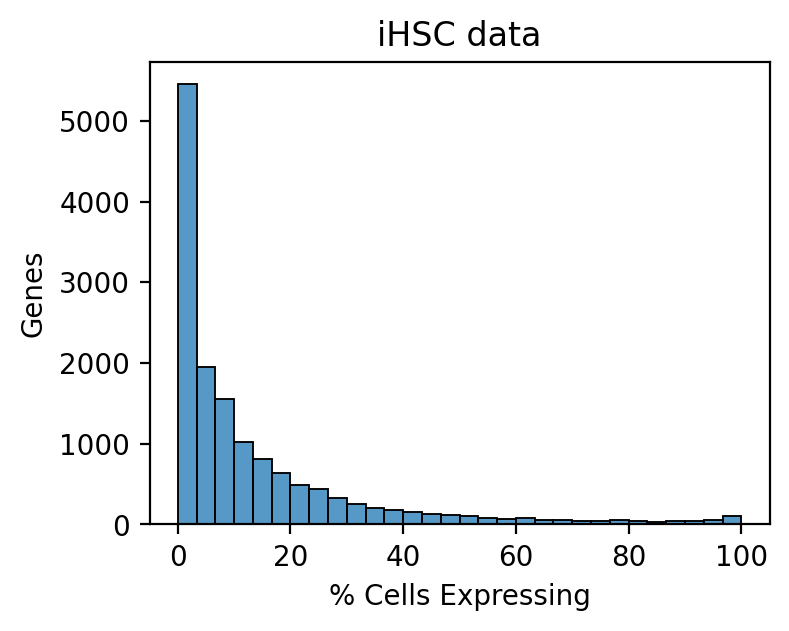

In [47]:
Xt = X.T.astype(bool)
print(f"{Xt.shape=}")
percent_expressing = (Xt.sum(axis=1) / Xt.shape[1]) * 100

sns.histplot(x=percent_expressing,
             bins=30)

plt.ylabel("Genes")
plt.xlabel("% Cells Expressing")
plt.title("iHSC data")

In [5]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)